In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from SALib.analyze import sobol

# to remove spines at the top and right
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [2]:
results = pd.read_csv('../data/concat_data.csv', index_col=0)
results['diff'] = results['newts_buffer'] - results['newts_corridor']

param_values = pd.read_csv('../data/parameter.csv', index_col=0)

problem = {
    'num_vars': 11,
    'names': [
        'number-of-startind', # 15
        'capacity',  # 20
        'mean-juvenile-mortality-prob', # 0.5
        'mean-adult-mortality-prob', #0.2
        'cropland-movement-cost', #5
        'woodland-movement-cost', #1
        'angle-for-viewing-ponds-and-woodland', #140
        'mortality-decrease-with-buffer', #0.1
        'distance-for-viewing-ponds-and-woodland', #2
        'movement-energy', #700
        'mean-number-of-female-offspring' #5
    ],
    'bounds': [
        [5, 80],
        [10, 40],
        [0.3, 0.7],
        [0.1, 0.3],
        [5, 7],
        [1, 4],
        [70, 180],
        [0.001, 0.2],
        [0.5, 3],
        [200, 1000],
        [4, 6]
    ]
}

results

,newts_buffer,newts_corridor,ponds_buffer,ponds_corridor,diff
0,28.0,0.0,3.0,0.0,28.0
1,7.0,5.0,1.0,2.0,2.0
2,18.0,5.0,4.0,1.0,13.0
3,39.0,59.0,3.0,7.0,-20.0
4,19.0,2.0,2.0,1.0,17.0
...,...,...,...,...,...
115,55.0,41.0,7.0,7.0,14.0
116,34.0,39.0,6.0,6.0,-5.0
117,37.0,36.0,6.0,7.0,1.0
118,58.0,38.0,6.0,7.0,20.0


In [3]:
problem['names']

['number-of-startind',
 'capacity',
 'mean-juvenile-mortality-prob',
 'mean-adult-mortality-prob',
 'cropland-movement-cost',
 'woodland-movement-cost',
 'angle-for-viewing-ponds-and-woodland',
 'mortality-decrease-with-buffer',
 'distance-for-viewing-ponds-and-woodland',
 'movement-energy',
 'mean-number-of-female-offspring']

In [4]:
problem['bounds']

[[5, 80],
 [10, 40],
 [0.3, 0.7],
 [0.1, 0.3],
 [5, 7],
 [1, 4],
 [70, 180],
 [0.001, 0.2],
 [0.5, 3],
 [200, 1000],
 [4, 6]]

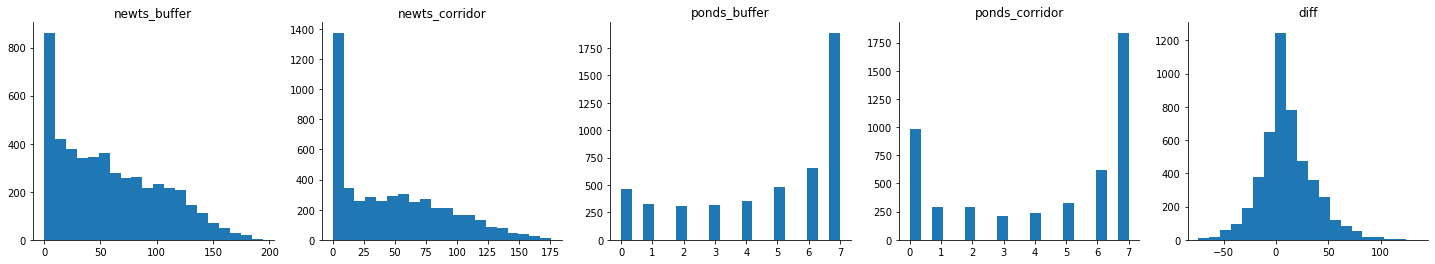

In [5]:
plt.figure(figsize=(25,4))
for i, output_name in enumerate(results.columns):
    plt.subplot(1, len(results.columns), i+1)
    plt.hist(results[output_name], 20)
    plt.title(output_name)

plt.subplots_adjust(wspace=0.2)
plt.savefig('../results/output_hist.svg')

In [6]:
from SALib.analyze import hdmr

y = results['newts_buffer'].values
Si_buffer = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['newts_corridor'].values
Si_corridor = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

y = results['diff'].values
Si_diff = hdmr.analyze(problem, param_values.values, y, print_to_console=False);

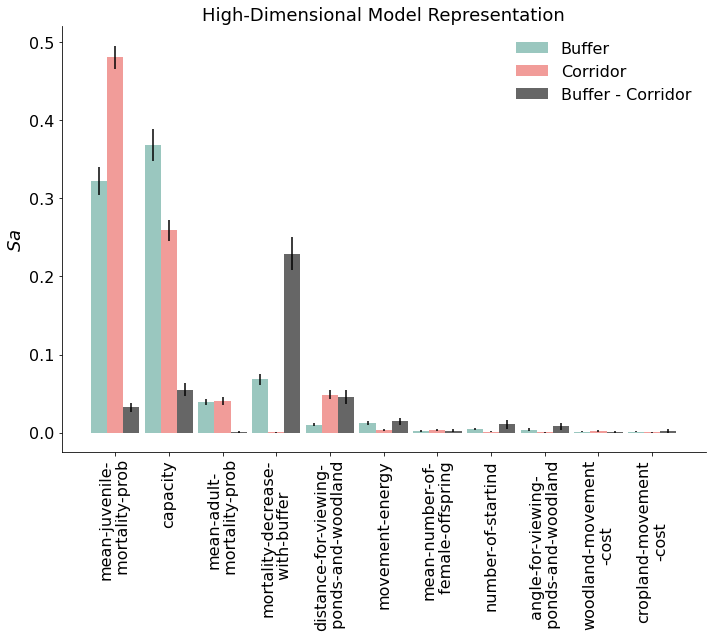

In [7]:
temp = np.array([Si_buffer['Sa'][0:11],
                 Si_corridor['Sa'][0:11]]).T

sorted_index = np.argsort(np.mean(temp, axis=1))[::-1]

order_no = 'Sa'
conf = f'{order_no}_conf'


##### labels --> xticks
np.array(Si_buffer['Term'])[sorted_index][0:11]
labels = ['mean-juvenile-\n mortality-prob', 
          'capacity',
         'mean-adult-\n mortality-prob',
         'mortality-decrease-\n with-buffer',
         'distance-for-viewing-\n ponds-and-woodland',
         'movement-energy',
         'mean-number-of-\n female-offspring',
         'number-of-startind',
         'angle-for-viewing-\n ponds-and-woodland',
         'woodland-movement\n-cost',
         'cropland-movement\n-cost']

plt.figure(figsize=(10,9))

plt.bar(np.arange(1,12)-0.3, Si_buffer[order_no][sorted_index][0:11], 
        yerr=Si_buffer[conf][sorted_index][0:11], 
        width=0.3, color='#9AC7BF', label='Buffer')

plt.bar(np.arange(1,12), Si_corridor[order_no][sorted_index][0:11], 
        yerr=Si_corridor[conf][sorted_index][0:11], 
        width=0.3, color='#F19C99', label='Corridor')

plt.bar(np.arange(1,12)+0.3, Si_diff[order_no][sorted_index][0:11], 
        yerr=Si_diff[conf][sorted_index][0:11], 
        width=0.3, color='#666666', label='Buffer - Corridor')

plt.xticks(np.arange(1,12), labels, rotation=90, size=16)
plt.yticks(fontsize=16)


plt.title('High-Dimensional Model Representation', size=18)
plt.ylabel(r'$Sa$', size=18)
plt.legend(frameon=False, prop={'size':16})

plt.tight_layout()
plt.savefig('../results/hdmr.svg');

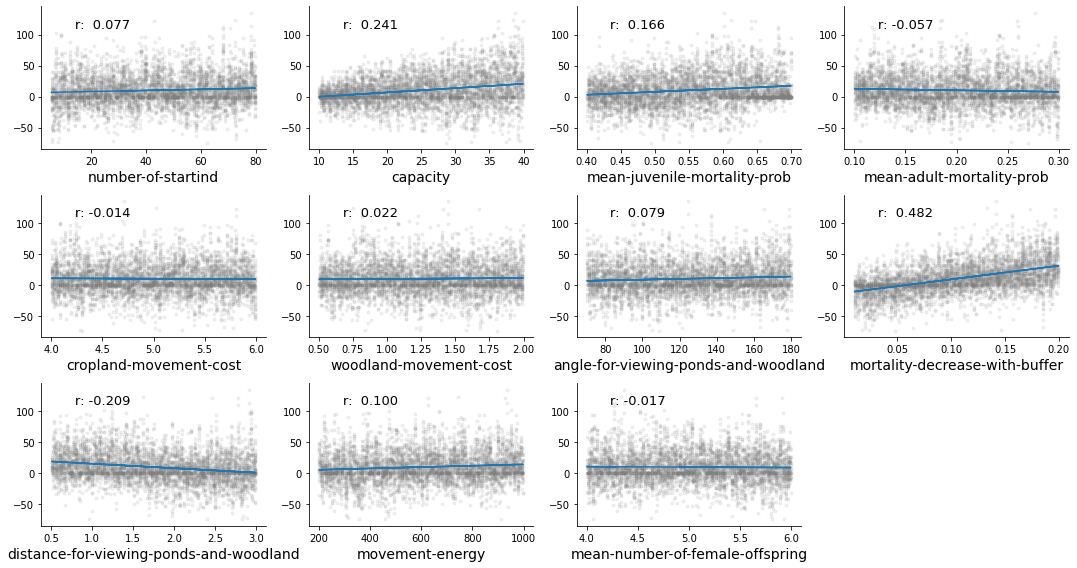

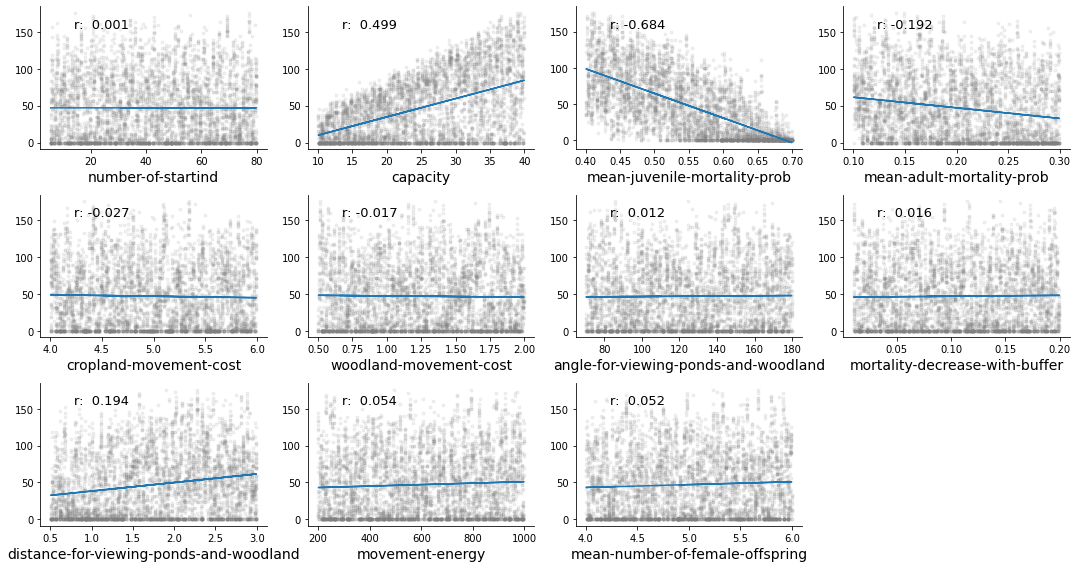

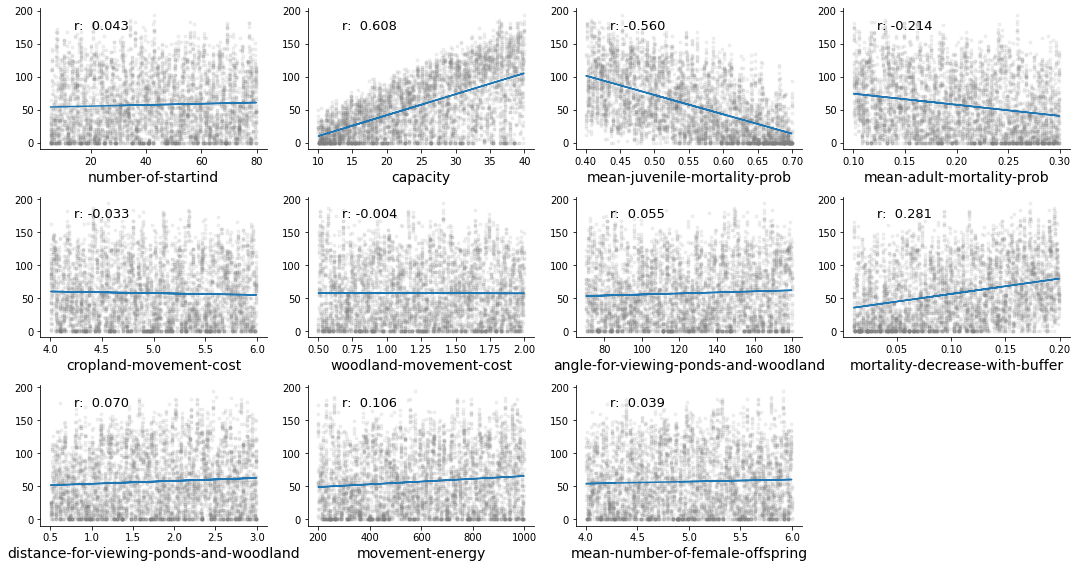

In [14]:
for scenario in ['diff', 'newts_corridor', 'newts_buffer']:
    
    plt.figure(figsize=(15,8))
    
    y = results[f'{scenario}']
    for i in range(11):
        plt.subplot(3,4,i+1)
        plt.xlabel(problem['names'][i], size=14)

        x = param_values.iloc[:,i]
        plt.plot(x,y, '.', alpha=0.1, color='gray')

        coef = np.polyfit(x,y,1)
        poly1d_fn = np.poly1d(coef) 
        plt.plot(x, poly1d_fn(x), '-')

        pearson = scipy.stats.pearsonr(x, y)
        plt.annotate("r: {:6.3f}".format(pearson[0]), xy=(0.15, 0.85), xycoords='axes fraction',fontsize=13)
        #print(pearson[1])

    plt.tight_layout()
    plt.savefig(f'../results/corr_{scenario}.png')

In [9]:
y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)

pd.DataFrame(Si_buffer['S2'])- pd.DataFrame(Si_buffer['S2_conf'])

,0,1,2,3,4,5,6,7,8,9,10
0,NaN,-0.068748,-0.081519,-0.079671,-0.078005,-0.077757,-0.087851,-0.079670,-0.080486,-0.077574,-0.064277
1,NaN,NaN,-0.067713,-0.098294,-0.074910,-0.097441,-0.085330,-0.081159,-0.073479,-0.047313,-0.092414
2,NaN,NaN,NaN,-0.106330,-0.154146,-0.105941,-0.137131,-0.126581,-0.161520,-0.151219,-0.158325
3,NaN,NaN,NaN,NaN,-0.113335,-0.104352,-0.107113,-0.094895,-0.104391,-0.120921,-0.091925
4,NaN,NaN,NaN,NaN,NaN,-0.013653,-0.027262,-0.012029,-0.016267,-0.011288,-0.015786
5,NaN,NaN,NaN,NaN,NaN,NaN,-0.042884,-0.052017,-0.049040,-0.045505,-0.035555
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.063255,-0.050327,-0.049868,-0.041112
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.037951,-0.021247,-0.025335
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.032081,-0.036712
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.060121


In [10]:
index_name, conf_name = 'S1', 'S1_conf' #'ST', 'ST_conf'

y = results['newts_buffer'].values
Si_buffer = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
buffer_df = pd.DataFrame({k:Si_buffer[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['newts_corridor'].values
Si_corridor = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
corridor_df = pd.DataFrame({k:Si_corridor[k] for k in [index_name,conf_name]},index=problem['names']) 

y = results['diff'].values
Si_diff = sobol.analyze(problem, y, calc_second_order=True, print_to_console=False)
diff_df = pd.DataFrame({k:Si_diff[k] for k in [index_name,conf_name]},index=problem['names']) 

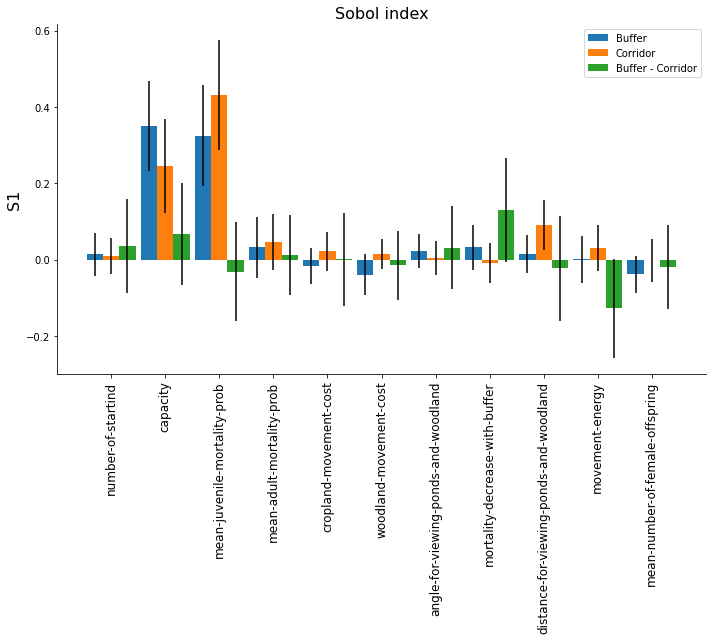

In [11]:
plt.figure(figsize=(10,9))
plt.bar(np.arange(1,12)-0.3, buffer_df[index_name], yerr=buffer_df[conf_name], width=0.3, label='Buffer')
plt.bar(np.arange(1,12), corridor_df[index_name], yerr=corridor_df[conf_name], width=0.3, label='Corridor')
plt.bar(np.arange(1,12)+0.3, diff_df[index_name], yerr=diff_df[conf_name], width=0.3, label='Buffer - Corridor')
plt.xticks(np.arange(1,12), buffer_df.index, rotation=90, size=12)
plt.title('Sobol index', size=16)
plt.ylabel(index_name, size=16)
plt.legend()
plt.tight_layout()
plt.savefig('../results/sobol.svg');